# KMeans

## 前処理

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
from replace import Country
country = Country()

pd.options.display.float_format = '{:.4f}'.format

visitors = pd.read_csv('data/visitors.csv')
gdp = pd.read_csv('data/gdp.csv')
currency = pd.read_csv('data/currency.csv')
continent = pd.read_csv('data/continent.csv')
cpi = pd.read_csv('data/cpi_japan.csv')
distance = pd.read_csv('data/distance.csv')
population = pd.read_csv('data/population.csv')

total = pd.read_csv("data/visitors.csv")

In [3]:
visitors["Country"] = visitors["Country"].replace(country.replace_list)
visitors = visitors.loc[~visitors["Country"].isin(country.list)]
visitors = visitors.loc[visitors["Year"] < 2020]

total = total.loc[total["Country"] == "総数"]
total.rename(columns={"Visitors":"Total_Visitors"}, inplace=True)
total.drop("Country", axis=1, inplace=True)

gdp = gdp.melt(id_vars="Country", var_name="Year", value_name="GDP")
gdp["Year"] = gdp.Year.astype(int)

population = population.melt(id_vars="Country", var_name="Year", value_name="Population")
population["Year"] = population.Year.astype(int)

In [4]:
df = pd.merge(total, visitors, on="Year", how="inner")
df = pd.merge(df, currency, on=["Country", "Year"], how="inner")
df = pd.merge(df, gdp, on=["Country", "Year"], how="inner")
df = pd.merge(df, cpi, on=["Country", "Year"], how="inner")
df = pd.merge(df, population, on=["Country", "Year"], how="inner")

In [5]:
df["CPI_Japan/CPI"] = df["CPI_Japan"] / df["CPI"]
df["GDPpc"] = df["GDP"] / df["Population"]
df["Visitors/Population"] = df["Visitors"] / df["Population"]

select = ['Year', 'Country', 'Visitors/Population', 'GDPpc', 'CPI_Japan/CPI']
df = df[select]

In [6]:
df = df.pivot_table(index="Country", columns="Year", values=['Visitors/Population', 'GDPpc', 'CPI_Japan/CPI'])
df.columns = ['_'.join(map(str, col)) for col in df.columns]
df = df.reset_index()

In [7]:
cpis = ['CPI_Japan/CPI_2010', 'CPI_Japan/CPI_2011',
       'CPI_Japan/CPI_2012', 'CPI_Japan/CPI_2013', 'CPI_Japan/CPI_2014',
       'CPI_Japan/CPI_2015', 'CPI_Japan/CPI_2016', 'CPI_Japan/CPI_2017',
       'CPI_Japan/CPI_2018', 'CPI_Japan/CPI_2019']
df["CPI_Japan/CPI_Total"] = 0
for cpi in cpis:
    df["CPI_Japan/CPI_Total"] += df[f"{cpi}"]
df["CPI_Japan/CPI_AVG"] = df["CPI_Japan/CPI_Total"]/len(cpis)

In [8]:
gdppcs = ['GDPpc_2010', 'GDPpc_2011',
       'GDPpc_2012', 'GDPpc_2013', 'GDPpc_2014', 'GDPpc_2015', 'GDPpc_2016',
       'GDPpc_2017', 'GDPpc_2018', 'GDPpc_2019']
df["GDPpc_Total"] = 0
for gdppc in gdppcs:
    df["GDPpc_Total"] += df[f"{gdppc}"]
df["GDPpc_AVG"] = df["GDPpc_Total"]/len(gdppcs)

In [9]:
vps = ['Visitors/Population_2010',
       'Visitors/Population_2011', 'Visitors/Population_2012',
       'Visitors/Population_2013', 'Visitors/Population_2014',
       'Visitors/Population_2015', 'Visitors/Population_2016',
       'Visitors/Population_2017', 'Visitors/Population_2018',
       'Visitors/Population_2019']
df["Visitors/Population_Total"] = 0
for vp in vps:
    df["Visitors/Population_Total"] += df[f"{vp}"]
df["Visitors/Population_AVG"] = df["Visitors/Population_Total"]/len(vps)

In [10]:
df = pd.merge(df, distance, on="Country", how="inner")
df["Distance"] = np.log(df["Distance"])

In [11]:
df = df[['Country', 'CPI_Japan/CPI_AVG', 'GDPpc_AVG', 'Visitors/Population_AVG', 'Distance']]

## 分析

In [12]:
from sklearn.preprocessing import MinMaxScaler

use_list = ['Country', 'CPI_Japan/CPI_AVG', 'GDPpc_AVG', 'Visitors/Population_AVG','Distance']

df_clustering = df[use_list]

df_clustering = df_clustering.set_index("Country")

In [13]:
scaler = MinMaxScaler()
df_clustering[df_clustering.columns] = scaler.fit_transform(df_clustering[df_clustering.columns])

In [14]:
inertia_values = []

k_range = range(1,10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_clustering)
    inertia_values.append(kmeans.inertia_)

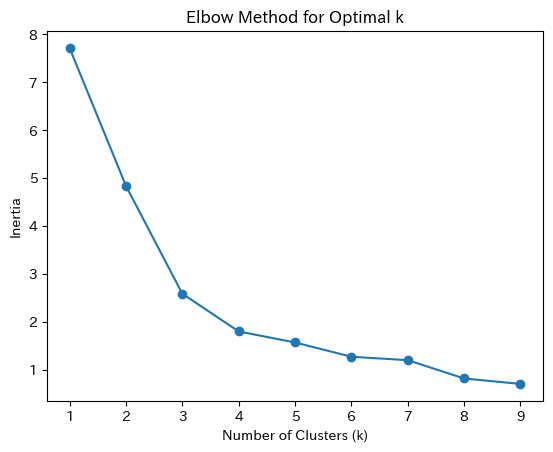

In [15]:
plt.plot(k_range, inertia_values, marker = "o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

# n_cluster = 5

In [16]:
kmeans = KMeans(n_clusters=5, random_state=42)

df_result_clustering = df_clustering.copy()
df_result_clustering["Country_Cluster"] = kmeans.fit_predict(df_clustering)
df_result_clustering["Country_Cluster"] = df_result_clustering["Country_Cluster"] + 1

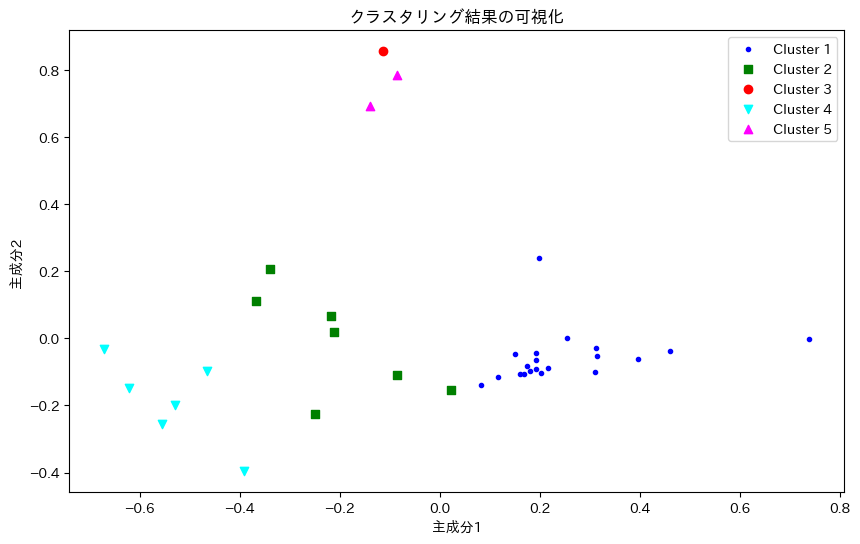

In [17]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_clustering)

plt.figure(figsize=(10,6))
colors = ["blue", "green", "red", "cyan", "magenta"]
markers = [".", ",", "o", "v", "^"]
for i in range(5):
    cluster_data = pca_result[df_result_clustering["Country_Cluster"]==i+1]
    plt.scatter(cluster_data[:,0], cluster_data[:,1], label=f"Cluster {i+1}", color = colors[i], marker = markers[i])

plt.title("クラスタリング結果の可視化")
plt.xlabel("主成分1")
plt.ylabel("主成分2")
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(df_clustering, df_result_clustering["Country_Cluster"])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.47353458187932773


In [19]:
df_result_clustering = df_result_clustering.reset_index()

df_add_cluster = pd.merge(df,
                          df_result_clustering[["Country", "Country_Cluster"]],
                          on="Country", how="left")
df_add_cluster.groupby("Country_Cluster").agg({"CPI_Japan/CPI_AVG":"mean","Country":"count"}).rename(columns={"CPI_Japan/CPI_AVG":"CPI_Japan/CPI_AVG","Country":"#_of_Countries"})

CPI_Japan/CPI_AVG  #_of_Countries
Country_Cluster                                   
1                           0.9555              20
2                           0.9195               7
3                           0.8656               1
4                           0.7643               6
5                           0.9566               2

In [20]:
use_list = ['CPI_Japan/CPI_AVG', 'GDPpc_AVG', 'Visitors/Population_AVG','Distance']

In [21]:
pd.pivot_table(df_add_cluster, values=use_list, index="Country_Cluster", aggfunc="mean", margins=True, margins_name="Total")

CPI_Japan/CPI_AVG  Distance  GDPpc_AVG  \
Country_Cluster                                           
1                           0.9555    8.6212 48096.1624   
2                           0.9195    8.1513  9756.1559   
3                           0.8656    7.4983 41959.0328   
4                           0.7643    8.4240  6055.0934   
5                           0.9566    6.9043 25327.6789   
Total                       0.9142    8.3704 32198.9247   

                 Visitors/Population_AVG  
Country_Cluster                           
1                                 0.0066  
2                                 0.0039  
3                                 0.1786  
4                                 0.0006  
5                                 0.1054  
Total                             0.0153

備考 (n_cluster = 5)

In [22]:
df_cluster1 = df_add_cluster.loc[df_add_cluster["Country_Cluster"]==1]
df_cluster2 = df_add_cluster.loc[df_add_cluster["Country_Cluster"]==2]
df_cluster3 = df_add_cluster.loc[df_add_cluster["Country_Cluster"]==3]
df_cluster4 = df_add_cluster.loc[df_add_cluster["Country_Cluster"]==4]
df_cluster5 = df_add_cluster.loc[df_add_cluster["Country_Cluster"]==5]

In [23]:
df_cluster1["Country"].unique()

array(['Australia', 'Austria', 'Belgium', 'Canada', 'Denmark', 'Finland',
       'France', 'Germany', 'Ireland', 'Israel', 'Italy', 'Netherlands',
       'New Zealand', 'Norway', 'Singapore', 'Spain', 'Sweden',
       'Switzerland', 'United Kingdom', 'United States'], dtype=object)

In [24]:
df_cluster2["Country"].unique()

array(['China', 'Malaysia', 'Mexico', 'Philippines', 'Poland', 'Portugal',
       'Thailand'], dtype=object)

In [25]:
df_cluster3["Country"].unique()

array(['Hong Kong'], dtype=object)

In [26]:
df_cluster4["Country"].unique()

array(['Brazil', 'India', 'Indonesia', 'Russia', 'Turkey', 'Vietnam'],
      dtype=object)

In [27]:
df_cluster5["Country"].unique()

array(['Korea', 'Taiwan'], dtype=object)

In [28]:
df_cluster1.describe()

CPI_Japan/CPI_AVG  GDPpc_AVG  Visitors/Population_AVG  Distance  \
count            20.0000    20.0000                  20.0000   20.0000   
mean              0.9555 48096.1624                   0.0066    8.6212   
std               0.0244 13777.9063                   0.0111    0.1525   
min               0.9241 26034.2367                   0.0015    8.0980   
25%               0.9418 40257.7937                   0.0026    8.5593   
50%               0.9506 44697.5310                   0.0034    8.6581   
75%               0.9640 55641.7360                   0.0042    8.6985   
max               1.0328 83814.9009                   0.0517    8.8106   

       Country_Cluster  
count          20.0000  
mean            1.0000  
std             0.0000  
min             1.0000  
25%             1.0000  
50%             1.0000  
75%             1.0000  
max             1.0000

In [29]:
df_cluster2.describe()

CPI_Japan/CPI_AVG  GDPpc_AVG  Visitors/Population_AVG  Distance  \
count             7.0000     7.0000                   7.0000    7.0000   
mean              0.9195  9756.1559                   0.0039    8.1513   
std               0.0318  5376.2860                   0.0039    0.6522   
min               0.8692  2944.0431                   0.0003    7.1763   
25%               0.9002  6773.5950                   0.0011    7.7418   
50%               0.9206  9556.9420                   0.0025    8.1080   
75%               0.9440 11268.8709                   0.0061    8.7159   
max               0.9586 19707.1744                   0.0097    8.8594   

       Country_Cluster  
count           7.0000  
mean            2.0000  
std             0.0000  
min             2.0000  
25%             2.0000  
50%             2.0000  
75%             2.0000  
max             2.0000

In [30]:
df_cluster3.describe()

CPI_Japan/CPI_AVG  GDPpc_AVG  Visitors/Population_AVG  Distance  \
count             1.0000     1.0000                   1.0000    1.0000   
mean              0.8656 41959.0328                   0.1786    7.4983   
std                  NaN        NaN                      NaN       NaN   
min               0.8656 41959.0328                   0.1786    7.4983   
25%               0.8656 41959.0328                   0.1786    7.4983   
50%               0.8656 41959.0328                   0.1786    7.4983   
75%               0.8656 41959.0328                   0.1786    7.4983   
max               0.8656 41959.0328                   0.1786    7.4983   

       Country_Cluster  
count           1.0000  
mean            3.0000  
std                NaN  
min             3.0000  
25%             3.0000  
50%             3.0000  
75%             3.0000  
max             3.0000

In [31]:
df_cluster4.describe()

CPI_Japan/CPI_AVG  GDPpc_AVG  Visitors/Population_AVG  Distance  \
count             6.0000     6.0000                   6.0000    6.0000   
mean              0.7643  6055.0934                   0.0006    8.4240   
std               0.0338  4003.4826                   0.0008    0.5460   
min               0.7283  1567.8780                   0.0001    7.7306   
25%               0.7467  2753.2230                   0.0002    8.1889   
50%               0.7529  6031.9089                   0.0003    8.3255   
75%               0.7773  9310.1405                   0.0007    8.5815   
max               0.8219 10635.6527                   0.0021    9.3523   

       Country_Cluster  
count           6.0000  
mean            4.0000  
std             0.0000  
min             4.0000  
25%             4.0000  
50%             4.0000  
75%             4.0000  
max             4.0000

In [32]:
df_cluster5.describe()

CPI_Japan/CPI_AVG  GDPpc_AVG  Visitors/Population_AVG  Distance  \
count             2.0000     2.0000                   2.0000    2.0000   
mean              0.9566 25327.6789                   0.1054    6.9043   
std               0.0243  4523.9522                   0.0364    0.3964   
min               0.9395 22128.7616                   0.0797    6.6241   
25%               0.9481 23728.2202                   0.0926    6.7642   
50%               0.9566 25327.6789                   0.1054    6.9043   
75%               0.9652 26927.1375                   0.1183    7.0445   
max               0.9738 28526.5961                   0.1312    7.1846   

       Country_Cluster  
count           2.0000  
mean            5.0000  
std             0.0000  
min             5.0000  
25%             5.0000  
50%             5.0000  
75%             5.0000  
max             5.0000

# n_cluster = 4

In [33]:
kmeans = KMeans(n_clusters=4, random_state=42)

df_result_clustering = df_clustering.copy()
df_result_clustering["Country_Cluster"] = kmeans.fit_predict(df_clustering)
df_result_clustering["Country_Cluster"] = df_result_clustering["Country_Cluster"] + 1

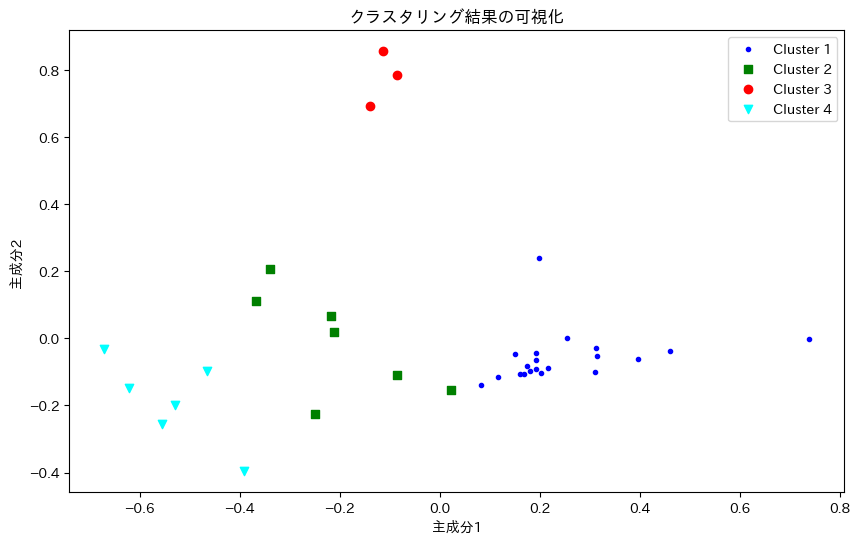

In [34]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_clustering)

plt.figure(figsize=(10,6))
colors = ["blue", "green", "red", "cyan"]
markers = [".", ",", "o", "v"]
for i in range(4):
    cluster_data = pca_result[df_result_clustering["Country_Cluster"]==i+1]
    plt.scatter(cluster_data[:,0], cluster_data[:,1], label=f"Cluster {i+1}", color = colors[i], marker = markers[i])

plt.title("クラスタリング結果の可視化")
plt.xlabel("主成分1")
plt.ylabel("主成分2")
plt.legend()
plt.show()

In [35]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(df_clustering, df_result_clustering["Country_Cluster"])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.48741027942183796


In [36]:
df_result_clustering = df_result_clustering.reset_index()

df_add_cluster = pd.merge(df,
                          df_result_clustering[["Country", "Country_Cluster"]],
                          on="Country", how="left")
df_add_cluster.groupby("Country_Cluster").agg({"CPI_Japan/CPI_AVG":"mean","Country":"count"}).rename(columns={"CPI_Japan/CPI_AVG":"CPI_Japan/CPI_AVG","Country":"#_of_Countries"})

CPI_Japan/CPI_AVG  #_of_Countries
Country_Cluster                                   
1                           0.9555              20
2                           0.9195               7
3                           0.9263               3
4                           0.7643               6

In [37]:
use_list = ['CPI_Japan/CPI_AVG', 'GDPpc_AVG', 'Visitors/Population_AVG','Distance']

In [38]:
pd.pivot_table(df_add_cluster, values=use_list, index="Country_Cluster", aggfunc="mean", margins=True, margins_name="Total")

CPI_Japan/CPI_AVG  Distance  GDPpc_AVG  \
Country_Cluster                                           
1                           0.9555    8.6212 48096.1624   
2                           0.9195    8.1513  9756.1559   
3                           0.9263    7.1023 30871.4635   
4                           0.7643    8.4240  6055.0934   
Total                       0.9142    8.3704 32198.9247   

                 Visitors/Population_AVG  
Country_Cluster                           
1                                 0.0066  
2                                 0.0039  
3                                 0.1298  
4                                 0.0006  
Total                             0.0153

備考 (n_cluster = 4)

In [39]:
df_cluster1 = df_add_cluster.loc[df_add_cluster["Country_Cluster"]==1]
df_cluster2 = df_add_cluster.loc[df_add_cluster["Country_Cluster"]==2]
df_cluster3 = df_add_cluster.loc[df_add_cluster["Country_Cluster"]==3]
df_cluster4 = df_add_cluster.loc[df_add_cluster["Country_Cluster"]==4]

In [40]:
df_cluster1["Country"].unique()

array(['Australia', 'Austria', 'Belgium', 'Canada', 'Denmark', 'Finland',
       'France', 'Germany', 'Ireland', 'Israel', 'Italy', 'Netherlands',
       'New Zealand', 'Norway', 'Singapore', 'Spain', 'Sweden',
       'Switzerland', 'United Kingdom', 'United States'], dtype=object)

In [41]:
df_cluster2["Country"].unique()

array(['China', 'Malaysia', 'Mexico', 'Philippines', 'Poland', 'Portugal',
       'Thailand'], dtype=object)

In [42]:
df_cluster3["Country"].unique()

array(['Hong Kong', 'Korea', 'Taiwan'], dtype=object)

In [43]:
df_cluster4["Country"].unique()

array(['Brazil', 'India', 'Indonesia', 'Russia', 'Turkey', 'Vietnam'],
      dtype=object)

# n_cluster = 3

In [44]:
kmeans = KMeans(n_clusters=3, random_state=42)

df_result_clustering = df_clustering.copy()
df_result_clustering["Country_Cluster"] = kmeans.fit_predict(df_clustering)
df_result_clustering["Country_Cluster"] = df_result_clustering["Country_Cluster"] + 1

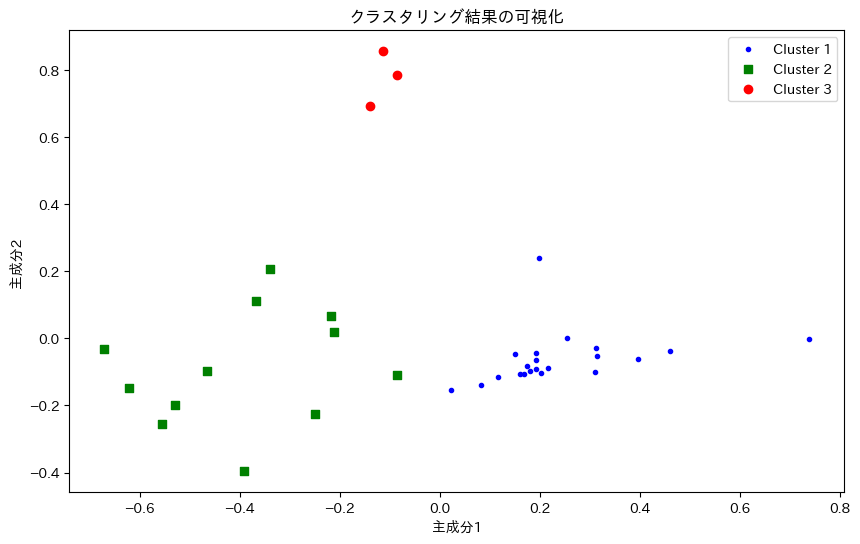

In [45]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_clustering)

plt.figure(figsize=(10,6))
colors = ["blue", "green", "red"]
markers = [".", ",", "o"]
for i in range(3):
    cluster_data = pca_result[df_result_clustering["Country_Cluster"]==i+1]
    plt.scatter(cluster_data[:,0], cluster_data[:,1], label=f"Cluster {i+1}", color = colors[i], marker = markers[i])

plt.title("クラスタリング結果の可視化")
plt.xlabel("主成分1")
plt.ylabel("主成分2")
plt.legend()
plt.show()

In [46]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(df_clustering, df_result_clustering["Country_Cluster"])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.5213346984231776


In [47]:
df_result_clustering = df_result_clustering.reset_index()

df_add_cluster = pd.merge(df,
                          df_result_clustering[["Country", "Country_Cluster"]],
                          on="Country", how="left")
df_add_cluster.groupby("Country_Cluster").agg({"CPI_Japan/CPI_AVG":"mean","Country":"count"}).rename(columns={"CPI_Japan/CPI_AVG":"CPI_Japan/CPI_AVG","Country":"#_of_Countries"})

CPI_Japan/CPI_AVG  #_of_Countries
Country_Cluster                                   
1                           0.9556              21
2                           0.8387              12
3                           0.9263               3

In [48]:
use_list = ['CPI_Japan/CPI_AVG', 'GDPpc_AVG', 'Visitors/Population_AVG','Distance']

In [49]:
pd.pivot_table(df_add_cluster, values=use_list, index="Country_Cluster", aggfunc="mean", margins=True, margins_name="Total")

CPI_Japan/CPI_AVG  Distance  GDPpc_AVG  \
Country_Cluster                                           
1                           0.9556    8.6319 46744.3058   
2                           0.8387    8.2298  7076.3731   
3                           0.9263    7.1023 30871.4635   
Total                       0.9142    8.3704 32198.9247   

                 Visitors/Population_AVG  
Country_Cluster                           
1                                 0.0063  
2                                 0.0024  
3                                 0.1298  
Total                             0.0153

備考 (n_cluster = 3)

In [50]:
df_cluster1 = df_add_cluster.loc[df_add_cluster["Country_Cluster"]==1]
df_cluster2 = df_add_cluster.loc[df_add_cluster["Country_Cluster"]==2]
df_cluster3 = df_add_cluster.loc[df_add_cluster["Country_Cluster"]==3]

In [51]:
df_cluster1["Country"].unique()

array(['Australia', 'Austria', 'Belgium', 'Canada', 'Denmark', 'Finland',
       'France', 'Germany', 'Ireland', 'Israel', 'Italy', 'Netherlands',
       'New Zealand', 'Norway', 'Portugal', 'Singapore', 'Spain',
       'Sweden', 'Switzerland', 'United Kingdom', 'United States'],
      dtype=object)

In [52]:
df_cluster2["Country"].unique()

array(['Brazil', 'China', 'India', 'Indonesia', 'Malaysia', 'Mexico',
       'Philippines', 'Poland', 'Russia', 'Thailand', 'Turkey', 'Vietnam'],
      dtype=object)

In [53]:
df_cluster3["Country"].unique()

array(['Hong Kong', 'Korea', 'Taiwan'], dtype=object)

In [54]:
df_cluster1.describe()

CPI_Japan/CPI_AVG  GDPpc_AVG  Visitors/Population_AVG  Distance  \
count            21.0000    21.0000                  21.0000   21.0000   
mean              0.9556 46744.3058                   0.0063    8.6319   
std               0.0238 14789.0840                   0.0109    0.1566   
min               0.9241 19707.1744                   0.0015    8.0980   
25%               0.9426 38147.1433                   0.0021    8.5610   
50%               0.9511 44619.3689                   0.0033    8.6661   
75%               0.9627 55377.8171                   0.0042    8.7072   
max               1.0328 83814.9009                   0.0517    8.8459   

       Country_Cluster  
count          21.0000  
mean            1.0000  
std             0.0000  
min             1.0000  
25%             1.0000  
50%             1.0000  
75%             1.0000  
max             1.0000

In [55]:
df_cluster2.describe()

CPI_Japan/CPI_AVG  GDPpc_AVG  Visitors/Population_AVG  Distance  \
count            12.0000    12.0000                  12.0000   12.0000   
mean              0.8387  7076.3731                   0.0024    8.2298   
std               0.0833  3699.5781                   0.0034    0.5979   
min               0.7283  1567.8780                   0.0001    7.1763   
25%               0.7530  3194.2943                   0.0003    7.8995   
50%               0.8455  8308.6774                   0.0007    8.1932   
75%               0.9079  9661.1688                   0.0027    8.5958   
max               0.9474 12563.8925                   0.0097    9.3523   

       Country_Cluster  
count          12.0000  
mean            2.0000  
std             0.0000  
min             2.0000  
25%             2.0000  
50%             2.0000  
75%             2.0000  
max             2.0000

In [56]:
df_cluster3.describe()

CPI_Japan/CPI_AVG  GDPpc_AVG  Visitors/Population_AVG  Distance  \
count             3.0000     3.0000                   3.0000    3.0000   
mean              0.9263 30871.4635                   0.1298    7.1023   
std               0.0553 10120.9543                   0.0495    0.4429   
min               0.8656 22128.7616                   0.0797    6.6241   
25%               0.9025 25327.6789                   0.1054    6.9043   
50%               0.9395 28526.5961                   0.1312    7.1846   
75%               0.9566 35242.8144                   0.1549    7.3415   
max               0.9738 41959.0328                   0.1786    7.4983   

       Country_Cluster  
count           3.0000  
mean            3.0000  
std             0.0000  
min             3.0000  
25%             3.0000  
50%             3.0000  
75%             3.0000  
max             3.0000